## Import Dependencies

In [1]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, RepeatVector, Concatenate, Bidirectional, LSTM,Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers


## Import Dataset

In [2]:
url = 'https://drive.google.com/uc?id=1kzzLkqeBPVxUr-9Ec0GPsPR7UqtRdeMk'
gdown.download(url, 'weather.csv', quiet=False)
df = pd.read_csv('weather.csv')


Downloading...
From (original): https://drive.google.com/uc?id=1kzzLkqeBPVxUr-9Ec0GPsPR7UqtRdeMk
From (redirected): https://drive.google.com/uc?id=1kzzLkqeBPVxUr-9Ec0GPsPR7UqtRdeMk&confirm=t&uuid=5a3f12ff-3deb-46a0-9b2c-af7ad1dc7eb1
To: d:\KULI\SEM 6\DBS\Capstone\HiPlan-ML\weather-prediction-model\weather.csv
100%|██████████| 132M/132M [00:22<00:00, 5.95MB/s] 


In [3]:
df.head(5)

,datetime,datetimeepoch,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,description,icon,stations,source,kecamatan,severerisk,day,month,weekday,year
0,2020-01-01,1577811600,31.1,20.6,24.8,36.9,20.6,26.0,22.0,85.6,...,partly cloudy throughout the day with rain in ...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,1,1,2,2020
1,2020-01-02,1577898000,33.2,19.2,24.7,39.3,19.2,25.8,21.2,82.5,...,partly cloudy throughout the day with late aft...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,2,1,3,2020
2,2020-01-03,1577984400,31.7,20.8,24.4,39.6,20.8,25.5,22.3,88.7,...,partly cloudy throughout the day with late aft...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,3,1,4,2020
3,2020-01-04,1578070800,31.2,20.4,24.4,39.1,20.4,25.5,22.0,87.3,...,partly cloudy throughout the day with afternoo...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,4,1,5,2020
4,2020-01-05,1578157200,31.2,20.6,25.0,37.4,20.6,26.2,22.0,84.7,...,partly cloudy throughout the day with early mo...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,5,1,6,2020


## Feature Engineering

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday

In [5]:
if 'kecamatan' in df.columns:
  df['pressure_diff'] = df.groupby('kecamatan')['pressure'].diff()

else:
  df['pressure_diff'] = df['pressure'].diff().fillna(0)

df['dew_point_spread'] = df['temp'] - df['dew']


In [6]:
LAG_PERIOD = 1
if 'kecamatan' in df.columns:
  df[f'humidity_lag{LAG_PERIOD}'] = df.groupby('kecamatan')['humidity'].shift(LAG_PERIOD)
  df[f'humidity_lag{LAG_PERIOD}'] = df[f'humidity_lag{LAG_PERIOD}'].fillna(df['humidity'].median())
else:
  df[f'humidity_lag{LAG_PERIOD}'] = df['humidity'].shift(LAG_PERIOD)
  df[f'humidity_lag{LAG_PERIOD}'] = df[f'humidity_lag{LAG_PERIOD}'].fillna(df['humidity'].median())

## Preprocessing

In [7]:
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [8]:
df.isna().sum()

datetime            0
datetimeepoch       0
tempmax             0
tempmin             0
temp                0
feelslikemax        0
feelslikemin        0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
precipcover         0
snow                0
snowdepth           0
windgust            0
windspeed           0
winddir             0
pressure            0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
sunrise             0
sunriseepoch        0
sunset              0
sunsetepoch         0
moonphase           0
conditions          0
description         0
icon                0
stations            0
source              0
kecamatan           0
severerisk          0
day                 0
month               0
weekday             0
year                0
pressure_diff       0
dew_point_spread    0
humidity_lag1       0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
targets = ['precipprob', 'windspeed', 'temp', 'humidity']

In [11]:
non_numerical_cols_to_remove = ['datetime', 'kecamatan', 'sunrise', 'sunset', 'conditions', 'icon', 'description', 'stations', 'source']

features = [
    col for col in df.select_dtypes(include=['int64', 'float64']).columns
    if col not in non_numerical_cols_to_remove and col not in targets and col != 'kecamatan_encoded'
]

date_features = ['year', 'month', 'day', 'weekday', 'pressure_diff', 'dew_point_spread', f'humidity_lag{LAG_PERIOD}']

features

['datetimeepoch',
 'tempmax',
 'tempmin',
 'feelslikemax',
 'feelslikemin',
 'feelslike',
 'dew',
 'precip',
 'precipcover',
 'snow',
 'snowdepth',
 'windgust',
 'winddir',
 'pressure',
 'cloudcover',
 'visibility',
 'solarradiation',
 'solarenergy',
 'uvindex',
 'sunriseepoch',
 'sunsetepoch',
 'moonphase',
 'severerisk',
 'pressure_diff',
 'dew_point_spread',
 'humidity_lag1']

In [12]:
label_encoder = LabelEncoder()
df['kecamatan_encoded'] = label_encoder.fit_transform(df['kecamatan'])
X_cat = df['kecamatan_encoded'].values.reshape(-1, 1)

In [13]:
non_numeric_cols = ['stations', 'source']
numeric_features = [col for col in features if col not in non_numeric_cols]

X_num = df[numeric_features].values

y = df[targets].values

In [14]:
feature_scaler = RobustScaler()
target_scaler = RobustScaler()
X_num_scaled = feature_scaler.fit_transform(X_num)
y_scaled = target_scaler.fit_transform(y)

## Split Data

In [15]:
def create_sequences(X_num, X_cat, y, time_steps=7):
  Xs_num, Xs_cat, ys = [], [], []
  for i in range(len(X_num) - time_steps):
    Xs_num.append(X_num[i:i+time_steps])
    Xs_cat.append(X_cat[i+time_steps])
    ys.append(y[i+time_steps])
  return np.array(Xs_num), np.array(Xs_cat), np.array(ys)

TIME_STEPS = 7
X_seq_num, X_seq_cat, y_seq = create_sequences(X_num_scaled, X_cat, y_scaled, TIME_STEPS)

In [16]:
dates = df['datetime'].values[TIME_STEPS:]
train_idx = [i for i, d in enumerate(dates) if pd.to_datetime(d).year <= 2023]
test_idx = [i for i, d in enumerate(dates) if pd.to_datetime(d).year > 2023]

In [17]:
X_train_num, X_train_cat, y_train = X_seq_num[train_idx], X_seq_cat[train_idx], y_seq[train_idx]
X_test_num, X_test_cat, y_test = X_seq_num[test_idx], X_seq_cat[test_idx], y_seq[test_idx]


## Model Building

In [18]:
n_features = X_train_num.shape[2]
n_kecamatan = df['kecamatan_encoded'].nunique()

input_num = Input(shape=(TIME_STEPS, n_features), name='numerical_input')
input_cat = Input(shape=(1,), name='kecamatan_input')

l2_lambda = 0.001

embedding_dim = 8
embedded_cat = Embedding(input_dim=n_kecamatan, output_dim=embedding_dim)(input_cat)
embedded_cat_flat = Flatten()(embedded_cat)
repeated_cat = RepeatVector(TIME_STEPS)(embedded_cat_flat)

combined = Concatenate()([input_num, repeated_cat])

x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(l2_lambda)))(combined)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(l2_lambda)))(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
output = Dense(len(targets))(x)

model = Model(inputs=[input_num, input_cat], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ kecamatan_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 8)      │      1,568 │ kecamatan_input[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 7, 26)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 7, 8)      │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 34)     │          0 │ numerical_input[… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 7, 128)    │     50,688 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 128)    │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        132 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,684 (373.77 KB)

 Trainable params: 95,684 (373.77 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
  [X_train_num, X_train_cat], y_train,
  validation_split=0.2,
  epochs=50,
  batch_size=32,
  callbacks=[early_stop],
  verbose=1
)

Epoch 1/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - loss: 191.3611 - mean_absolute_error: 4.0095 - val_loss: 231.9261 - val_mean_absolute_error: 4.7743
Epoch 2/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 173.5249 - mean_absolute_error: 3.7530 - val_loss: 218.8546 - val_mean_absolute_error: 4.4660
Epoch 3/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 169.6272 - mean_absolute_error: 3.6696 - val_loss: 212.8428 - val_mean_absolute_error: 4.3350
Epoch 4/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - loss: 166.0251 - mean_absolute_error: 3.5949 - val_loss: 212.2008 - val_mean_absolute_error: 4.3190
Epoch 5/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - loss: 160.5522 - mean_absolute_error: 3.4903 - val_loss: 212.3490 - val_mean_absolute_error: 4.1090
Epoch 6/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - loss: 154.1869 - mean_absolute_error: 3.3619 - val_loss: 215.0869 - val_mean_absolute_error: 4.3334
Epoch 7/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - l

## Model Evaluation

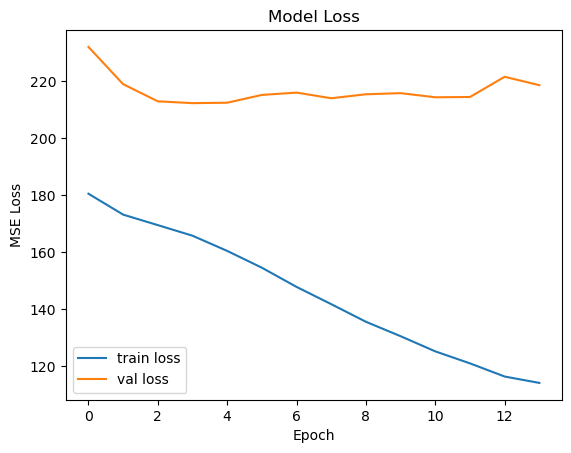

In [20]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [21]:
y_pred_scaled = model.predict([X_test_num, X_test_cat])
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test)

metrics = {}
for i, target_name in enumerate(targets):
  mse = mean_squared_error(y_true[:, i], y_pred[:, i])
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
  r2 = r2_score(y_true[:, i], y_pred[:, i])
  metrics[target_name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

for target_name, vals in metrics.items():
  print(f"Metrics for {target_name}:")
  print(f"  MSE: {vals['MSE']:.4f}")
  print(f"  RMSE: {vals['RMSE']:.4f}")
  print(f"  MAE: {vals['MAE']:.4f}")
  print(f"  R2: {vals['R2']:.4f}")
  print()

3005/3005 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Metrics for precipprob:
  MSE: 1000.6117
  RMSE: 31.6324
  MAE: 16.8852
  R2: 0.3014

Metrics for windspeed:
  MSE: 38.4400
  RMSE: 6.2000
  MAE: 4.4154
  R2: 0.3024

Metrics for temp:
  MSE: 2.9711
  RMSE: 1.7237
  MAE: 1.2237
  R2: 0.7105

Metrics for humidity:
  MSE: 26.5953
  RMSE: 5.1571
  MAE: 3.6536
  R2: 0.5023



## Save Model

In [22]:
preprocessor_save_path = 'weather_preprocessors.pkl'
features_list_save_path = 'weather_feature_list.pkl'

with open(preprocessor_save_path, 'wb') as f:
    pickle.dump({
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler,
        'label_encoder': label_encoder
    }, f)
print(f"Preprocessors saved to {preprocessor_save_path}")

with open(features_list_save_path, 'wb') as f:
    pickle.dump(features, f) 
print(f"Feature list saved to {features_list_save_path}")

Preprocessors saved to weather_preprocessors.pkl
Feature list saved to weather_feature_list.pkl


In [23]:
keras_model_save_path = 'weather_prediction_lstm_model.keras'
model.save(keras_model_save_path)
print(f"Model saved to {keras_model_save_path}")

Model saved to weather_prediction_lstm_model.keras


In [24]:
model.export('weather_prediction_lstm_model/')

INFO:tensorflow:Assets written to: weather_prediction_lstm_model/assets


INFO:tensorflow:Assets written to: weather_prediction_lstm_model/assets


Saved artifact at 'weather_prediction_lstm_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 7, 26), dtype=tf.float32, name='numerical_input'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='kecamatan_input')]
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2385373601936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2385373601552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2385373604048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2385373607504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2385373606928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2385373604816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2385373606160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2385373606544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2385373606736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2385373609232: